In [2]:
import math
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [8]:
!git clone https://github.com/1277120515/MachineLearning.git
!unzip MachineLearning/fer2013.zip -d .
# ! rm -rf MachineLearning

Cloning into 'MachineLearning'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3
Unpacking objects: 100% (3/3), done.
Archive:  MachineLearning/fer2013.zip
  inflating: ./fer2013.csv           


# 1. Load DataSet

In [9]:
df = pd.read_csv('fer2013.csv')
print("shape:", df.shape)
df.head()

shape: (35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


### data overview

total pixel of image: 2304


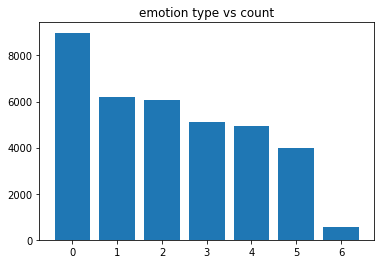

In [10]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
print("total pixel of image:", len(df.pixels[0].split(' ')))
df.emotion.value_counts()
plt.bar(range(7), df.emotion.value_counts().values)
plt.title("emotion type vs count")
plt.show()

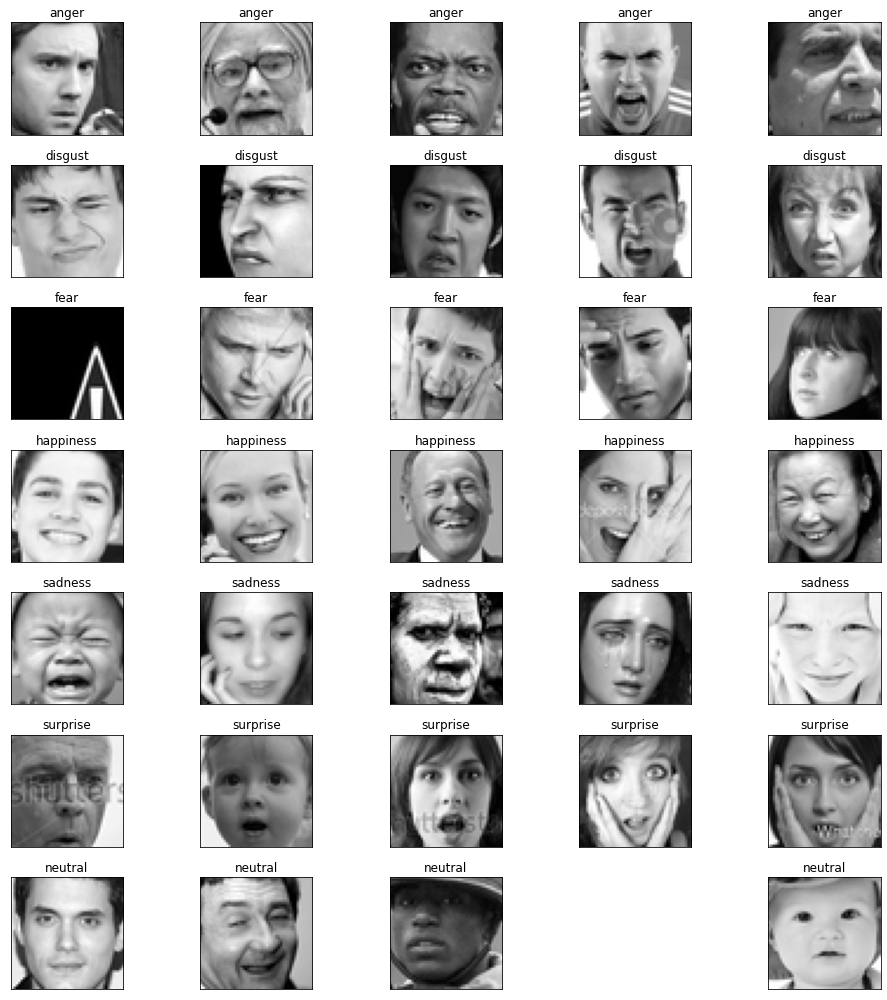

In [11]:
plt.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(5):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 5, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

### convert data into numpy array

In [12]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis=0)
print(img_array.shape)
img_features = []
for i in range(len(img_array)):
    img_features.append(cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB))
    
# convert 1-D image to 3-D image
img_features = np.array(img_features)
print(img_features.shape)


(35887, 48, 48)
(35887, 48, 48, 3)


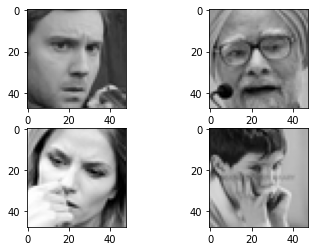

In [13]:
for i in range(4):
    plt.subplot(2,2,i + 1)
    plt.imshow(img_features[i].astype(np.uint8))


In [14]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
print(img_labels.shape)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

(35887, 7)
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


### Split into train data and test data

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(
    img_features, img_labels,shuffle=True, 
    stratify=img_labels,test_size=0.1, random_state=42)

# Normalizing results
X_train = X_train / 255.
X_valid = X_valid / 255.

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [15]:
# del df
# del img_features
# del img_labels


In [16]:
_, img_width, img_height, img_depth = X_train.shape
_, num_classes = y_train.shape


## 2. Prepare for Model

In [17]:
vgg = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(48, 48, 3)
)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [18]:
for layer in vgg.layers:
    layer.trainable = False

In [19]:

top_model = vgg.layers[-2].output
top_model = GlobalAveragePooling2D()(top_model)
# top_model = BatchNormalization(name='batchnorm_1')(top_model)
# top_model = Dropout(0.5, name='dropout_2')(top_model)
top_model = Dense(num_classes, activation='softmax', name='out_layer')(top_model)

model = Model(inputs = vgg.input, outputs = top_model)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [34]:

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train )

batch_size = 32  
epochs = 25

# compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
    metrics=['accuracy']
)

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)



Train for 1009.3125 steps, validate on 3589 samples
Epoch 1/25
1010/1009 [==============================] - 42s 41ms/step - loss: 1.4037 - accuracy: 0.4580 - val_loss: 1.1980 - val_accuracy: 0.5456
Epoch 2/25
1010/1009 [==============================] - 37s 37ms/step - loss: 1.1752 - accuracy: 0.5559 - val_loss: 1.0817 - val_accuracy: 0.5876
Epoch 3/25
1010/1009 [==============================] - 38s 37ms/step - loss: 1.0957 - accuracy: 0.5863 - val_loss: 1.0604 - val_accuracy: 0.5988
Epoch 4/25
1010/1009 [==============================] - 38s 37ms/step - loss: 1.0348 - accuracy: 0.6095 - val_loss: 0.9799 - val_accuracy: 0.6375
Epoch 5/25
1010/1009 [==============================] - 38s 37ms/step - loss: 0.9900 - accuracy: 0.6286 - val_loss: 0.9760 - val_accuracy: 0.6342
Epoch 6/25
1010/1009 [==============================] - 38s 37ms/step - loss: 0.9524 - accuracy: 0.6449 - val_loss: 0.9326 - val_accuracy: 0.6581
Epoch 7/25
1010/1009 [==============================] - 37s 37ms/step -

# 3. Evaluate

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

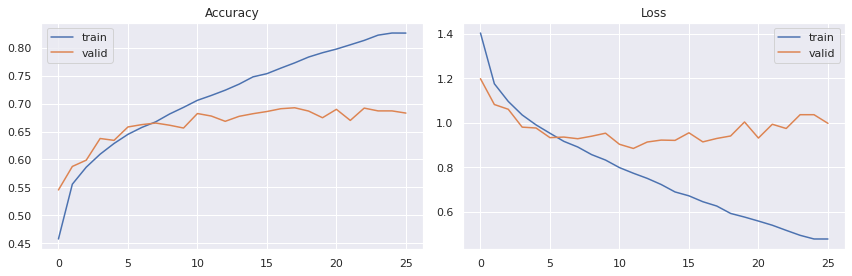

In [37]:
sns.set()
fig = plt.figure(0, (12, 4))
ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()
ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()
plt.show()